In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

dataset_url = "dataset"
data_dir = pathlib.Path(dataset_url).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

98


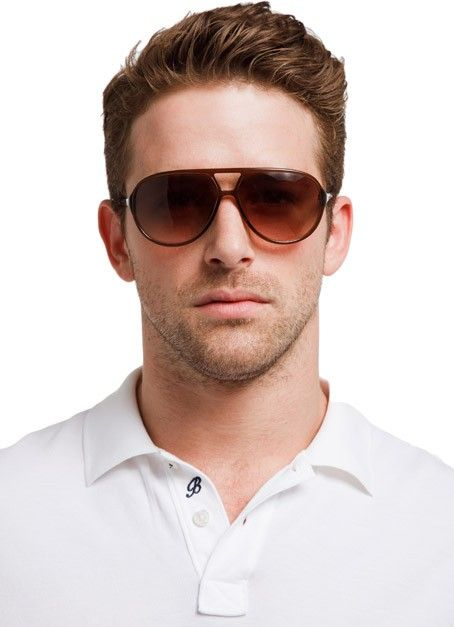

In [4]:
heart = list(data_dir.glob('Heart/*'))
PIL.Image.open(str(heart[0]))

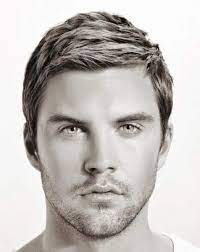

In [5]:
oblong = list(data_dir.glob('Oblong/*'))
PIL.Image.open(str(oblong[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 98 files belonging to 7 classes.


Using 79 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 98 files belonging to 7 classes.


Using 19 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['diamond', 'heart', 'oblong', 'oval', 'round', 'square', 'triangle']


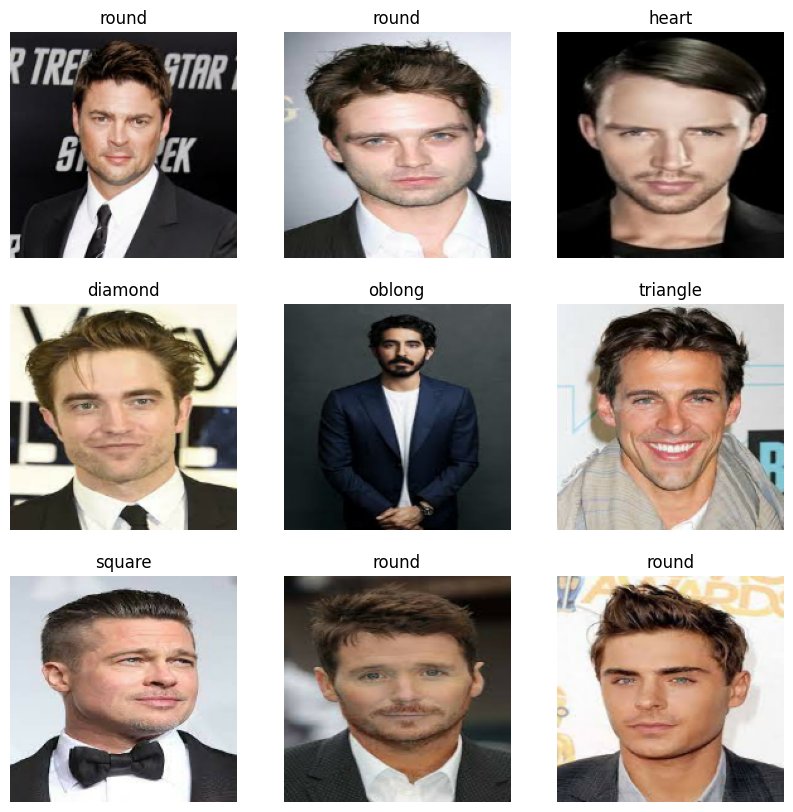

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.871446


In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


3/3 [==============================] - 2s 321ms/step - loss: 3.4369 - accuracy: 0.1519 - val_loss: 2.1604 - val_accuracy: 0.1053
Epoch 2/10
3/3 [==============================] - 1s 231ms/step - loss: 2.3749 - accuracy: 0.1392 - val_loss: 1.8637 - val_accuracy: 0.3158
Epoch 3/10
3/3 [==============================] - 1s 304ms/step - loss: 2.0410 - accuracy: 0.2025 - val_loss: 1.9164 - val_accuracy: 0.1579
Epoch 4/10
3/3 [==============================] - 1s 245ms/step - loss: 1.9320 - accuracy: 0.2658 - val_loss: 2.0426 - val_accuracy: 0.1053
Epoch 5/10
3/3 [==============================] - 1s 243ms/step - loss: 1.8193 - accuracy: 0.3671 - val_loss: 1.9990 - val_accuracy: 0.1579
Epoch 6/10
3/3 [==============================] - 1s 245ms/step - loss: 1.6916 - accuracy: 0.4937 - val_loss: 2.0088 - val_accuracy: 0.1053
Epoch 7/10
3/3 [==============================] - 1s 314ms/step - loss: 1.5620 - accuracy: 0.5190 - val_loss: 1.9408 - val_accuracy: 0.2632
Epoch 8/10
3/3 [===============

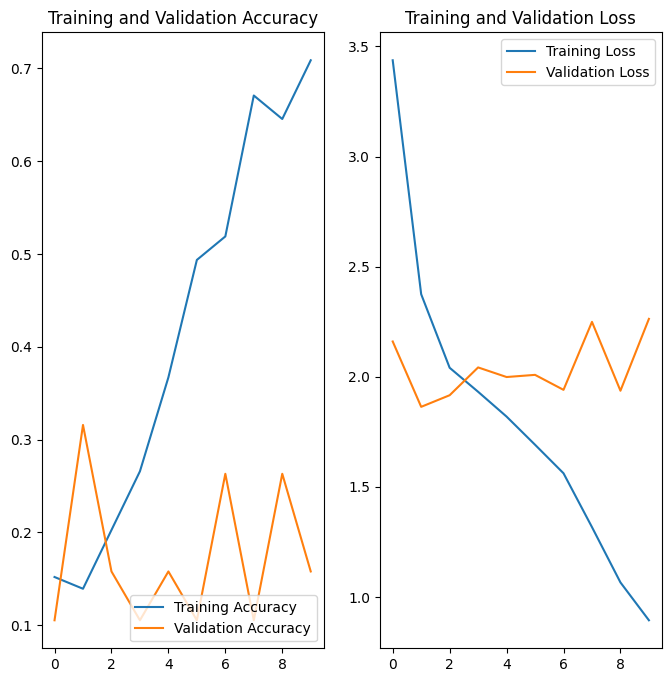

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

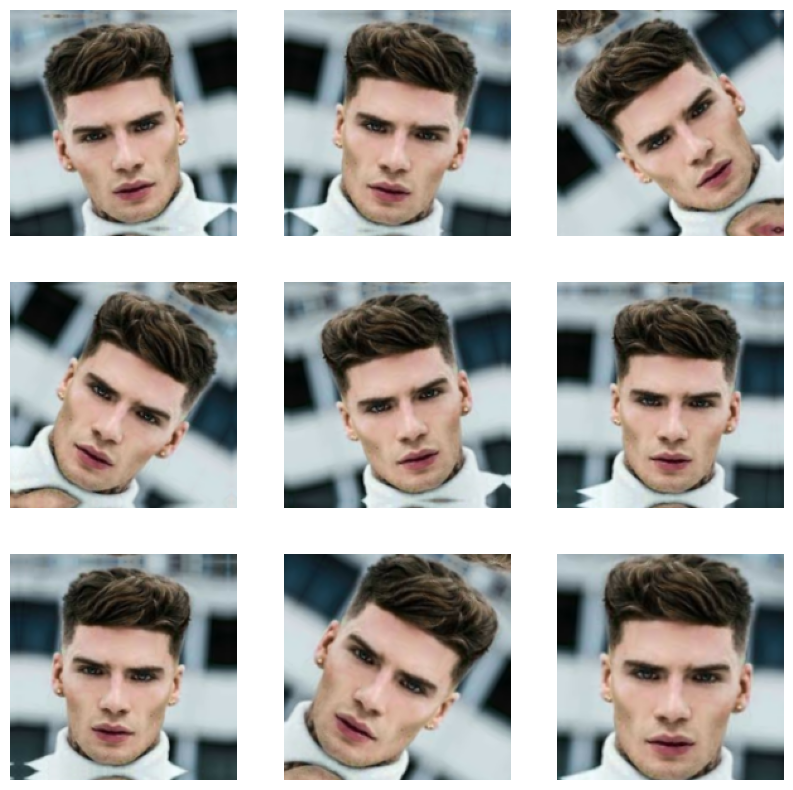

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 2s 388ms/step - loss: 2.7619 - accuracy: 0.1013 - val_loss: 1.9996 - val_accuracy: 0.1053
Epoch 2/15
3/3 [==============================] - 1s 335ms/step - loss: 1.9490 - accuracy: 0.2278 - val_loss: 1.9805 - val_accuracy: 0.1053
Epoch 3/15
3/3 [==============================] - 1s 281ms/step - loss: 1.9244 - accuracy: 0.1772 - val_loss: 1.9734 - val_accuracy: 0.0526
Epoch 4/15
3/3 [==============================] - 1s 275ms/step - loss: 1.9149 - accuracy: 0.1772 - val_loss: 1.9922 - val_accuracy: 0.1053
Epoch 5/15
3/3 [==============================] - 1s 302ms/step - loss: 1.8980 - accuracy: 0.2278 - val_loss: 2.0322 - val_accuracy: 0.1053
Epoch 6/15
3/3 [==============================] - 1s 289ms/step - loss: 1.8739 - accuracy: 0.2278 - val_loss: 2.0306 - val_accuracy: 0.1053
Epoch 7/15
3/3 [==============================] - 1s 341ms/step - loss: 1.8613 - accuracy: 0.2405 - val_loss: 2.0391 - val_accuracy: 0.1053
Epoch 8/15
3/3 [====

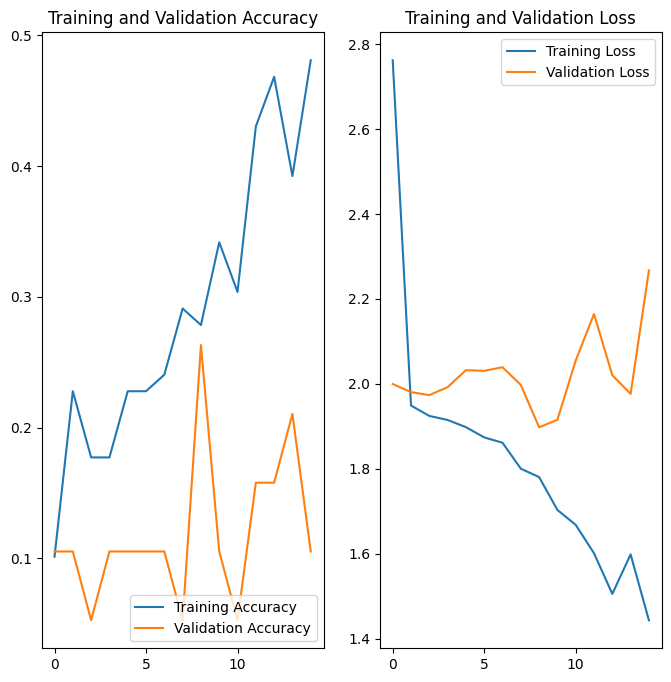

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()